# Machine Learning Approach to Classifying Cystic Neck Masses using Head & Neck CT Imaging

Author: Alexandra Bourdillon      
Date: December 2021

***Aim 1: Develop ML classifiers using radiomics features***       
***Aim 2: Develop CNN classifier using CT voxel data***

# Setup (load packages and define functions)

In [57]:
# ----------------- import packages

# ----- general pkgs 
import numpy as np
import pandas as pd
import os 
import glob
import sys
import csv
import itertools
import pickle as pkl
import _pickle as cPickle
from pathlib import Path
from collections import OrderedDict


# ----- printing/markdown pkgs
import pprint
import yaml
from IPython.display import Markdown, display

# ----- radiomics pkgs 
import nrrd
# import gdcm
# import radiomics
# import six
from radiomics import featureextractor 
# from __future__ import print_function


# ----- visualization pks
import matplotlib.pyplot as plt
import pylibjpeg
from matplotlib.colors import NoNorm
import ipywidgets as widgets
from IPython import display
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Error loading C extensions
Traceback (most recent call last):
  File "/Users/alexandrabourdillon/miniconda3/lib/python3.9/site-packages/radiomics/__init__.py", line 286, in <module>
    from radiomics import _cmatrices as cMatrices  # noqa: F401
ImportError: numpy.core.multiarray failed to import
Error loading C extensions
Traceback (most recent call last):
  File "/Users/alexandrabourdillon/miniconda3/lib/python3.9/site-packages/radiomics/__init__.py", line 286, in <module>
    from radiomics import _cmatrices as cMatrices  # noqa: F401
ImportError: numpy.core.multiarray failed to import
Error loading C extensions
Traceback (most recent call last):
  File "/Users/alexandrabourdillon/miniconda3/lib/python3.9/site-packages/radiomics/__init__.py", line 286, in <module>
    from radiomics import _cmatrices as cMatrices  # noqa: F401
ImportError: numpy.core.multiarray failed to import
Error loading C extensions
Traceback (most recent call last):
  File "/Users/alexandrabourdillon/miniconda

ImportError: numpy.core.multiarray failed to import

In [56]:
np.path

AttributeError: module 'numpy' has no attribute 'path'

In [47]:
# ----------------- define functions

def bbox2_3D(img):
    """
    Returns 3D coordinates of bounding box around segmentation mask.
    
    Args
    ----
    img -- 3D voxel input
    """
    
    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

def extract_voxel_data(list_of_dicom_files):
    """
    Returns np array of voxel data.
    
    Args
    ----
    list_of_dicom_files -- List of paths to dicom files
    """
    datasets = [dicom.read_file(f) for f in list_of_dicom_files]
    try:
        voxel_ndarray, ijk_to_xyz = dicom_numpy.combine_slices(datasets)
    except dicom_numpy.DicomImportException as e:
        # invalid DICOM data
        raise
    return voxel_ndarray

# -------  Function: listdir_nohidden
# Description: return directory items without hidden objects
def listdir_nohidden(path):
    """Returns list of directory items without hidden objects."""
    return glob.glob(os.path.join(path, '*'))


def pickle_save(obj, filename):
    """ Saves object as pickle file."""
    filehandler = open(filename, 'wb') 
    return pkl.dump(obj, filehandler )
    
    

def pickle_load(file_path):
    """ Loads pickle object at file_path."""
    filehandler = open(file_path, 'rb') 
    return pkl.load(filehandler )



# Load clinical data

In [52]:

# read in outcomes from excel sheet
outcome_df = pd.read_excel('/Users/alexandrabourdillon/Documents/Yale/Oto/DL_LN_Thesis/outcome_sept1.xlsm', sheet_name ="outcome" )

# preprocessing clinical data: format, subset columns, sort by ID and remove NAs, 
outcome_df = pd.DataFrame(outcome_df)[['ID', 'final_grade', 'dx_class']]
outcome_df = outcome_df.sort_values(["ID"]) 
outcome_df = outcome_df[outcome_df['ID'].notna()]
display(outcome_df)


ID  final_grade dx_class
0    001          4.0   benign
1    002          2.0   cancer
2    003          2.0   benign
3    004          4.0   benign
4    005          3.0   cancer
..   ...          ...      ...
204  201          4.0   cancer
205  202          4.0   cancer
206  203          4.0   benign
207  204          2.0   cancer
208  205          2.0   benign

[209 rows x 3 columns]

# Loading Raw Dicom Images + Pre-processing CT slices

In [48]:
# Load and review all cases in directory, "data_path"
data_path = Path(r'/Users/alexandrabourdillon/Documents/Yale/Oto/DL_LN_Thesis/SEGMENTATIONS/segmentations_aug27')
all_cases = os.listdir(data_path)

id_labels = []
for case_dir in all_cases:
    id_labels.append(case_dir)
    
if '.DS_Store' in all_cases:
    all_cases.remove('.DS_Store')


print("List of all cases: \n", all_cases, "\n")
num_cases =  len(all_cases)
print("Number of total cases: ", num_cases)

# save cases
pickle_save(all_cases, 'all_cases_sept20.pickle')

List of all cases: 
 ['132', '103', '168', '192', '194', '193', '024', '015', '137b', '014', '047', '096', '053', '098', '038', '009', '204', '203', '052', '090', '037', '205', '001', '174', '162c', '036a', '128b', '129', '116', '111', '118', '143', '144', '162b', '121', '119', '079b', '117', '165', '190', '155', '199', '130', '042', '137a', '080', '027', '016', '075', '086', '044', '017', '010', '003', '004', '200', '059', '201', '005', '002', '051', '112', '115', '036b', '148', '128a', '125', '114', '079a', '182', '176', '185'] 

Number of total cases:  72


In [10]:
# Loop through cases and store max dimensions 
# to define dimensions of empty numpy array

metadata_list = []
    
max_width_ct = 0
max_length_ct = 0
max_depth_ct = 0

max_width_seg = 0
max_length_seg = 0
max_depth_seg = 0

for case_dir in all_cases:
    # load segmentation path
    mask = os.path.join(data_path, case_dir, "Segmentation.seg.nrrd")
    if os.path.exists(mask):
        #print(mask)
        # read CT scan and metadata
        ct_path = os.path.join(data_path, case_dir, case_dir + ".nrrd")
        data_ct, header =  nrrd.read(ct_path)
        
        # update "max" width, length and depth variables for CT scan if indicated
        if data_ct.shape[0] > max_width_ct:
            max_width_ct = data_ct.shape[0]
        if data_ct.shape[1] > max_length_ct:
            max_length_ct = data_ct.shape[1]
        if data_ct.shape[2] > max_depth_ct:
            max_depth_ct = data_ct.shape[2]
        
        # read segmentation mask and metadata
        data_mask, header = nrrd.read(mask)
        rmin, rmax, cmin, cmax, zmin, zmax  = bbox2_3D(data_mask)
        r_dim = rmax - rmin
        c_dim = cmax - cmin
        z_dim = zmax- zmin
        
        # update "max" width, length and depth variables for masks if indicated
        if r_dim > max_width_seg:
            max_width_seg = r_dim
        if c_dim > max_length_seg:
            max_length_seg = c_dim
        if z_dim > max_depth_seg:
            max_depth_seg = z_dim
            
        metadata_list.append({
            "path" : mask,
            "ct_dimensions" : data_ct.shape, 
            "mask_dimensions" : [r_dim, c_dim, z_dim],
            })
        # print dimensions
        # print("CT Scan dimensions: ", )
        #print("Segmentation Mask object dimensions: ", )
        
            
print("max_width_seg: ", max_width_seg)
print("max_length_seg: ", max_length_seg)
print("max_depth_seg: ", max_depth_seg)

print("max_width_ct: ", max_width_ct)
print("max_length_ct: ", max_length_ct)
print("max_depth_ct: ", max_depth_ct)


KeyboardInterrupt: 

In [ ]:
# Loop through each CT scan, load slices and multiply by mask to generate dataset of 
# segmented data in "dataset_boxed"


# Create np array of zeros with dimensions from "max" width, length, depth  
dataset_boxed = np.zeros((max_width_seg, max_length_seg, max_depth_seg, num_cases))

# keep track of case (subject)
c = 0

for case_dir in all_cases:
    seg_mask = os.path.join(data_path, case_dir, "Segmentation.seg.nrrd")
    print(seg_mask)
    if os.path.exists(seg_mask):
        # load segmentation mask and metadata 
        data_seg, header_seg = nrrd.read(seg_mask)
        # load segmentation offset from metadata
        offset_x = int(header_seg['Segmentation_ReferenceImageExtentOffset'].split()[0])
        offset_y = int(header_seg['Segmentation_ReferenceImageExtentOffset'].split()[1])
        offset_z = int(header_seg['Segmentation_ReferenceImageExtentOffset'].split()[2])

        # load CT scan and metadata 
        ct_path = os.path.join(data_path, case_dir, case_dir + ".nrrd")
        data_ct, header =  nrrd.read(ct_path)
        
        # store segmentation 
        mask_df = np.zeros(data_ct.shape)
        mask_df[offset_x:(offset_x + data_seg.shape[0]),
                offset_y:(offset_y + data_seg.shape[1]), 
                offset_z:(offset_z + data_seg.shape[2])] = data_seg

        # store segmentation
        data_mask_bbox = bbox2_3D(mask_df)
        #print("bbox: ", data_mask_bbox)
        rmin, rmax, cmin, cmax, zmin, zmax = data_mask_bbox
        r_dim = rmax - rmin
        c_dim = cmax - cmin
        z_dim = zmax- zmin
        
        # store voxel data by multiply ct scan array with mask 
        final_df = mask_df.astype(int) * data_ct
        #print("final_df shape: ", np.shape(final_df))
        
        # plot and save image for review
        plt.imshow(final_df[rmin:rmax, cmin:cmax, (zmin + round(z_dim/2))],  
                   cmap = plt.cm.gray)
        plt.savefig('/Users/alexandrabourdillon/Documents/Yale/Oto/DL_LN_Thesis/code/plots/' + case_dir + ".png")
        #plt.show() 

        # store data in "dataset_boxed" by updating appropriate voxels of the "c"th case
        case_height = np.shape(final_df)[2]
        dataset_boxed[0:r_dim, 0:c_dim, 0:z_dim, c] = final_df[rmin:rmax, cmin:cmax, zmin:zmax]

        # increment c by 1
        c = c + 1
        
print("dataset_boxed shape: ", np.shape(dataset_boxed))    

pickle_save(dataset_boxed, 'dataset_boxed.pickle')

# Skip to Load Data

In [11]:
max_width_seg = 199
max_length_seg = 154
max_depth_seg = 167
max_width_ct = 512
max_length_ct = 512
max_depth_ct =  484

#dataset_boxed = np.zeros((max_width_seg, max_length_seg, max_depth_seg, num_cases))

path = Path("/Users/alexandrabourdillon/Documents/Yale/Oto/DL_LN_Thesis/code/data/dataset_boxed_0_29.pickle")
filehandler = open(path, 'rb') 
dataset_full_1 = pkl.load(filehandler)
path = Path("/Users/alexandrabourdillon/Documents/Yale/Oto/DL_LN_Thesis/code/data/dataset_boxed_30_59.pickle")
filehandler = open(path, 'rb') 
dataset_full_2 = pkl.load(filehandler)
path = Path("/Users/alexandrabourdillon/Documents/Yale/Oto/DL_LN_Thesis/code/data/dataset_boxed_60_72.pickle")
filehandler = open(path, 'rb') 
dataset_full_3 = pkl.load(filehandler)

dataset_full = np.zeros((199, 154, 167, 72))
dataset_full[:,:,:,0:29] = dataset_full_1
dataset_full[:,:,:,30:59] = dataset_full_2
dataset_full[:,:,:,60:72] = dataset_full_3


# Begin Pyradiomics Analysis

In [49]:
# Create csv of file paths for for pyradiomics analysis
mask_path_list = []
ct_path_list = []

for case_dir in all_cases:
    mask = os.path.join(data_path, case_dir, "Segmentation.seg.nrrd")
    mask_path_list.append(mask)
    if os.path.exists(mask):
        ct_path = os.path.join(data_path, case_dir, case_dir + ".nrrd")
        ct_path_list.append(ct_path)

d = {'ID':all_cases, 'Image': ct_path_list, 'Mask': mask_path_list }

In [50]:
# save dataframe of paths as csv and review 
df = pd.DataFrame(d)
#df.to_csv('../data/pyradiomics_paths.csv')
df

ID                                              Image  \
0    132  /Users/alexandrabourdillon/Documents/Yale/Oto/...   
1    103  /Users/alexandrabourdillon/Documents/Yale/Oto/...   
2    168  /Users/alexandrabourdillon/Documents/Yale/Oto/...   
3    192  /Users/alexandrabourdillon/Documents/Yale/Oto/...   
4    194  /Users/alexandrabourdillon/Documents/Yale/Oto/...   
..   ...                                                ...   
67   114  /Users/alexandrabourdillon/Documents/Yale/Oto/...   
68  079a  /Users/alexandrabourdillon/Documents/Yale/Oto/...   
69   182  /Users/alexandrabourdillon/Documents/Yale/Oto/...   
70   176  /Users/alexandrabourdillon/Documents/Yale/Oto/...   
71   185  /Users/alexandrabourdillon/Documents/Yale/Oto/...   

                                                 Mask  
0   /Users/alexandrabourdillon/Documents/Yale/Oto/...  
1   /Users/alexandrabourdillon/Documents/Yale/Oto/...  
2   /Users/alexandrabourdillon/Documents/Yale/Oto/...  
3   /Users/alexandrabourdillon/Documents/Yale/Oto/...  
4   /Users/alexandrabourdillon/Documents/Yale/Oto/...  
..                                                ...  
67  /Users/alexandrabourdillon/Documents/Yale/Oto/...  
68  /Users/alexandrabourdillon/Documents/Yale/Oto/...  
69  /Users/alexandrabourdillon/Documents/Yale/Oto/...  
70  /Users/alexandrabourdillon/Documents/Yale/Oto/...  
71  /Users/alexandrabourdillon/Documents/Yale/Oto/...  

[72 rows x 3 columns]

# Radiomics: Feature Extraction

### Instantiate Radiomic feature extractor

Links:     
feature extraction example: https://notebook.community/Radiomics/pyradiomics/notebooks/PyRadiomicsExample     
feature visualization: https://notebook.community/Radiomics/pyradiomics/notebooks/FeatureVisualization 


In [51]:
# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(
    correctMask = True, 
    resegmentRange = [1,300],
    interpolator = 3)

display(Markdown('**Extraction parameters:** '))
print(yaml.dump(extractor.settings, sort_keys=False, default_flow_style=False))

display(Markdown('**Enabled features:**'))
print(yaml.dump(extractor.enabledFeatures, sort_keys=False, default_flow_style=False))

NameError: name 'featureextractor' is not defined

### Extract features using optimized parameters


In [10]:
num_samples = len(df['ID']) 
features = {}

for i in range(0, num_samples):
    result = extractor.execute(df.loc[i].at['Image'], df.loc[i].at['Mask'])
    features[df.loc[i].at['ID']] = result
        
# feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features[1] )))

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

### Convert features from dictionary into dataframe

In [11]:
feature_df = pd.DataFrame(features)

# save csv
feature_df.to_csv('../data/feature_df_01.csv')

# save pickle file
pickle_save(feature_df, 'feature_df_02.pickle')

In [13]:
feature_df

132     103     168     192  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  v3.0.1  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  1.21.4  1.21.4   
diagnostics_Versions_SimpleITK                 2.0.2   2.0.2   2.0.2   2.0.2   
diagnostics_Versions_PyWavelet                 1.1.1   1.1.1   1.1.1   1.1.1   
diagnostics_Versions_Python                    3.9.5   3.9.5   3.9.5   3.9.5   
...                                              ...     ...     ...     ...   
diagnostics_Mask-corrected_CenterOfMassIndex     NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_CenterOfMass          NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Mean                  NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Minimum               NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Maximum               NaN     NaN     NaN     NaN   

                                                 194     193     024     015  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  v3.0.1  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  1.21.4  1.21.4   
diagnostics_Versions_SimpleITK                 2.0.2   2.0.2   2.0.2   2.0.2   
diagnostics_Versions_PyWavelet                 1.1.1   1.1.1   1.1.1   1.1.1   
diagnostics_Versions_Python                    3.9.5   3.9.5   3.9.5   3.9.5   
...                                              ...     ...     ...     ...   
diagnostics_Mask-corrected_CenterOfMassIndex     NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_CenterOfMass          NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Mean                  NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Minimum               NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Maximum               NaN     NaN     NaN     NaN   

                                                137b     014  ...     115  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  ...  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  ...  1.21.4   
diagnostics_Versions_SimpleITK                 2.0.2   2.0.2  ...   2.0.2   
diagnostics_Versions_PyWavelet                 1.1.1   1.1.1  ...   1.1.1   
diagnostics_Versions_Python                    3.9.5   3.9.5  ...   3.9.5   
...                                              ...     ...  ...     ...   
diagnostics_Mask-corrected_CenterOfMassIndex     NaN     NaN  ...     NaN   
diagnostics_Mask-corrected_CenterOfMass          NaN     NaN  ...     NaN   
diagnostics_Mask-corrected_Mean                  NaN     NaN  ...     NaN   
diagnostics_Mask-corrected_Minimum               NaN     NaN  ...     NaN   
diagnostics_Mask-corrected_Maximum               NaN     NaN  ...     NaN   

                                                036b     148    128a     125  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  v3.0.1  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  1.21.4  1.21.4   
diagnostics_Versions_SimpleITK                 2.0.2   2.0.2   2.0.2   2.0.2   
diagnostics_Versions_PyWavelet                 1.1.1   1.1.1   1.1.1   1.1.1   
diagnostics_Versions_Python                    3.9.5   3.9.5   3.9.5   3.9.5   
...                                              ...     ...     ...     ...   
diagnostics_Mask-corrected_CenterOfMassIndex     NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_CenterOfMass          NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Mean                  NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Minimum               NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Maximum               NaN     NaN     NaN     NaN   

                                                 114    079a     182     176  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  v3.0.1  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  1.21.4  1.21.4   
d

### Load features from pickle for analysis

In [58]:
path = Path("/Users/alexandrabourdillon/Documents/Yale/Oto/DL_LN_Thesis/code/radiomics_01/feature_df_02.pickle")
feature_df = pickle_load(path)

In [59]:
feature_df

132     103     168     192  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  v3.0.1  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  1.21.4  1.21.4   
diagnostics_Versions_SimpleITK                 2.0.2   2.0.2   2.0.2   2.0.2   
diagnostics_Versions_PyWavelet                 1.1.1   1.1.1   1.1.1   1.1.1   
diagnostics_Versions_Python                    3.9.5   3.9.5   3.9.5   3.9.5   
...                                              ...     ...     ...     ...   
diagnostics_Mask-corrected_CenterOfMassIndex     NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_CenterOfMass          NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Mean                  NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Minimum               NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Maximum               NaN     NaN     NaN     NaN   

                                                 194     193     024     015  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  v3.0.1  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  1.21.4  1.21.4   
diagnostics_Versions_SimpleITK                 2.0.2   2.0.2   2.0.2   2.0.2   
diagnostics_Versions_PyWavelet                 1.1.1   1.1.1   1.1.1   1.1.1   
diagnostics_Versions_Python                    3.9.5   3.9.5   3.9.5   3.9.5   
...                                              ...     ...     ...     ...   
diagnostics_Mask-corrected_CenterOfMassIndex     NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_CenterOfMass          NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Mean                  NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Minimum               NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Maximum               NaN     NaN     NaN     NaN   

                                                137b     014  ...     115  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  ...  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  ...  1.21.4   
diagnostics_Versions_SimpleITK                 2.0.2   2.0.2  ...   2.0.2   
diagnostics_Versions_PyWavelet                 1.1.1   1.1.1  ...   1.1.1   
diagnostics_Versions_Python                    3.9.5   3.9.5  ...   3.9.5   
...                                              ...     ...  ...     ...   
diagnostics_Mask-corrected_CenterOfMassIndex     NaN     NaN  ...     NaN   
diagnostics_Mask-corrected_CenterOfMass          NaN     NaN  ...     NaN   
diagnostics_Mask-corrected_Mean                  NaN     NaN  ...     NaN   
diagnostics_Mask-corrected_Minimum               NaN     NaN  ...     NaN   
diagnostics_Mask-corrected_Maximum               NaN     NaN  ...     NaN   

                                                036b     148    128a     125  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  v3.0.1  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  1.21.4  1.21.4   
diagnostics_Versions_SimpleITK                 2.0.2   2.0.2   2.0.2   2.0.2   
diagnostics_Versions_PyWavelet                 1.1.1   1.1.1   1.1.1   1.1.1   
diagnostics_Versions_Python                    3.9.5   3.9.5   3.9.5   3.9.5   
...                                              ...     ...     ...     ...   
diagnostics_Mask-corrected_CenterOfMassIndex     NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_CenterOfMass          NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Mean                  NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Minimum               NaN     NaN     NaN     NaN   
diagnostics_Mask-corrected_Maximum               NaN     NaN     NaN     NaN   

                                                 114    079a     182     176  \
diagnostics_Versions_PyRadiomics              v3.0.1  v3.0.1  v3.0.1  v3.0.1   
diagnostics_Versions_Numpy                    1.21.4  1.21.4  1.21.4  1.21.4   
d

# ML Classifiers using Extracted Radiomics Features

In [60]:
# ---------------- import packages

# ------- stats and generic pkgs
from scipy.stats import sem
from numpy import mean
from numpy import std
from pprint import pprint
from operator import itemgetter

# ------- ML pkgs
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm

from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm


In [61]:
def evaluate(model, test_features, test_labels):
    """Evaluates performance of model on test data"""
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


def run_lr_cv( X, y, repeats):
    """Fit and evaluate Logistic Regression.

    Args
    ----
    X -- features
    y -- targets (classes)
    repeats -- number of repeats for kfold cross-validation

    Returns
    -------
    scores -- [dict] from cross_val_score()
    """
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # create model
    model = LogisticRegression()
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

def report(grid_scores, n_top=3):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

    return top_scores[0].parameters

def run_lr_gridsearch(X, y, model, param_grid, cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(model,
                               param_grid=param_grid,
                               cv=cv)
    grid_search.fit(X, y)
    
    print('The parameters combination that would give best accuracy is : ')
    print(grid_search.best_params_)
    print('The best accuracy achieved after parameter tuning via grid search is : ', grid_search.best_score_)
    
    
    return  grid_search.best_estimator_


def run_dt_gridsearch(X, y, model, param_grid, cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(model,
                               param_grid=param_grid,
                               cv=cv)
    grid_search.fit(X, y)
    
    print('The parameters combination that would give best accuracy is : ')
    print(grid_search.best_params_)
    print('The best accuracy achieved after parameter tuning via grid search is : ', grid_search.best_score_)
    
    
    return  grid_search.best_estimator_

In [28]:
feature_df.dropna().copy().stack().unstack(0).rename_axis("ID").reset_index().columns.values

array(['ID', 'diagnostics_Versions_PyRadiomics',
       'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK',
       'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python',
       'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing',
       'diagnostics_Image-original_Size',
       'diagnostics_Image-original_Mean',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_Hash',
       'diagnostics_Mask-original_Spacing',
       'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-original_VolumeNum',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Mask-res

### Create X and y dataframes

In [31]:
################ temporary code
from sklearn.model_selection import train_test_split
outcome_df

# remove NA values
feature_df_filtered = feature_df.dropna().copy()
feature_df_filtered = feature_df_filtered.stack().unstack(0)
feature_df_filtered = feature_df_filtered.rename_axis("ID").reset_index()

# subset relevant columns
filter_col = [col for col in feature_df_filtered if col.startswith(('original', 'ID'))]
feature_df_filtered = feature_df_filtered[filter_col].copy()


combined_df = feature_df_filtered.merge(outcome_df, left_on = "ID", right_on = "ID" )
outcome_train, outcome_test = train_test_split(combined_df, test_size = 0.2, random_state = 4)

print(np.shape(outcome_train))
print(np.shape(outcome_test))
# display(outcome_train)
# display(outcome_test)
outcome_train.groupby('dx_class').count()
outcome_test.groupby('dx_class').count()

ID  final_grade dx_class
0    001          4.0   benign
1    002          2.0   cancer
2    003          2.0   benign
3    004          4.0   benign
4    005          3.0   cancer
..   ...          ...      ...
204  201          4.0   cancer
205  202          4.0   cancer
206  203          4.0   benign
207  204          2.0   cancer
208  205          2.0   benign

[209 rows x 3 columns]

(57, 110)
(15, 110)


ID  original_shape_Elongation  original_shape_Flatness  \
dx_class                                                           
benign    26                         26                       26   
cancer    30                         30                       30   
cancer     1                          1                        1   

          original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
dx_class                                                                   
benign                                26                              26   
cancer                                30                              30   
cancer                                 1                               1   

          original_shape_Maximum2DDiameterColumn  \
dx_class                                           
benign                                        26   
cancer                                        30   
cancer                                         1   

          original_shape_Maximum2DDiameterRow  \
dx_class                                        
benign                                     26   
cancer                                     30   
cancer                                      1   

          original_shape_Maximum2DDiameterSlice  \
dx_class                                          
benign                                       26   
cancer                                       30   
cancer                                        1   

          original_shape_Maximum3DDiameter  original_shape_MeshVolume  ...  \
dx_class                                                               ...   
benign                                  26                         26  ...   
cancer                                  30                         30  ...   
cancer                                   1                          1  ...   

          original_glszm_SmallAreaLowGrayLevelEmphasis  \
dx_class                                                 
benign                                              26   
cancer                                              30   
cancer                                               1   

          original_glszm_ZoneEntropy  original_glszm_ZonePercentage  \
dx_class                                                              
benign                            26                             26   
cancer                            30                             30   
cancer                             1                              1   

          original_glszm_ZoneVariance  original_ngtdm_Busyness  \
dx_class                                                         
benign                             26                       26   
cancer                             30                       30   
cancer                              1                        1   

          original_ngtdm_Coarseness  original_ngtdm_Complexity  \
dx_class                                                         
benign                           26                         26   
cancer                           30                         30   
cancer                            1                          1   

          original_ngtdm_Contrast  original_ngtdm_Strength  final_grade  
dx_class                                                                 
benign                         26                       26           26  
cancer                         30                       30           30  
cancer                          1                        1            1  

[3 rows x 109 columns]

ID  original_shape_Elongation  original_shape_Flatness  \
dx_class                                                           
benign     4                          4                        4   
cancer     8                          8                        8   
cancer     2                          2                        2   
temp       1                          1                        1   

          original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
dx_class                                                                   
benign                                 4                               4   
cancer                                 8                               8   
cancer                                 2                               2   
temp                                   1                               1   

          original_shape_Maximum2DDiameterColumn  \
dx_class                                           
benign                                         4   
cancer                                         8   
cancer                                         2   
temp                                           1   

          original_shape_Maximum2DDiameterRow  \
dx_class                                        
benign                                      4   
cancer                                      8   
cancer                                      2   
temp                                        1   

          original_shape_Maximum2DDiameterSlice  \
dx_class                                          
benign                                        4   
cancer                                        8   
cancer                                        2   
temp                                          1   

          original_shape_Maximum3DDiameter  original_shape_MeshVolume  ...  \
dx_class                                                               ...   
benign                                   4                          4  ...   
cancer                                   8                          8  ...   
cancer                                   2                          2  ...   
temp                                     1                          1  ...   

          original_glszm_SmallAreaLowGrayLevelEmphasis  \
dx_class                                                 
benign                                               4   
cancer                                               8   
cancer                                               2   
temp                                                 1   

          original_glszm_ZoneEntropy  original_glszm_ZonePercentage  \
dx_class                                                              
benign                             4                              4   
cancer                             8                              8   
cancer                             2                              2   
temp                               1                              1   

          original_glszm_ZoneVariance  original_ngtdm_Busyness  \
dx_class                                                         
benign                              4                        4   
cancer                              8                        8   
cancer                              2                        2   
temp                                1                        1   

          original_ngtdm_Coarseness  original_ngtdm_Complexity  \
dx_class                                                         
benign                            4                          4   
cancer                            8                          8   
cancer                            2                          2   
temp                              1                          1   

          original_ngtdm_Contrast  original_ngtdm_Strength  final_grade  
dx_class                                                                 
benign                          4         

In [65]:
# ---------- Process extracted features

# remove NA values
feature_df_filtered = feature_df.dropna().copy()
feature_df_filtered = feature_df_filtered.stack().unstack(0)
feature_df_filtered = feature_df_filtered.rename_axis("ID").reset_index()

# subset relevant columns
filter_col = [col for col in feature_df_filtered if col.startswith(('original', 'ID'))]
feature_df_filtered = feature_df_filtered[filter_col].copy()

# merge feature dataframe with clninical data
combined_df = feature_df_filtered.merge(outcome_df, left_on = "ID", right_on = "ID" )
combined_df['cancer_code'] = combined_df.dx_class.eq('cancer').mul(1)
combined_df = combined_df.drop([ 'ID', 'final_grade', 'dx_class'], axis = 1)
combined_df

# create X and y dataframes
X = combined_df.drop(['cancer_code'], axis = 1).copy()
y = combined_df['cancer_code']

X_norm = (X - X.min(axis = 0))/(X.max(axis = 0) - X.min(axis = 0))

original_shape_Elongation original_shape_Flatness  \
0                   0.436748                 0.42784   
1                     0.8948                0.731316   
2                   0.746259                0.674841   
3                    0.61287                0.436631   
4                   0.925643                0.812136   
..                       ...                     ...   
67                  0.798426                0.734301   
68                  0.908918                0.709205   
69                  0.612269                0.563761   
70                  0.560007                0.502447   
71                  0.737961                 0.60714   

   original_shape_LeastAxisLength original_shape_MajorAxisLength  \
0                       18.919136                      44.220133   
1                       32.939477                      45.041357   
2                       18.709028                      27.723589   
3                       15.856408                      36.315312   
4                       17.895233                      22.034762   
..                            ...                            ...   
67                      15.754737                       21.45542   
68                      18.074558                       25.48565   
69                      11.725975                      20.799543   
70                      14.194318                      28.250358   
71                      20.913256                      34.445506   

   original_shape_Maximum2DDiameterColumn original_shape_Maximum2DDiameterRow  \
0                       48.94766986417068                   48.90624984025565   
1                       53.83924091841973                   46.38020374248447   
2                      30.278025124461205                   33.46970537220489   
3                       32.36234642080058                   31.37345002492037   
4                       26.61861868804344                  28.038734673483386   
..                                    ...                                 ...   
67                     24.409029451209573                  24.114220258021124   
68                     29.665148864094817                   29.32241013221652   
69                     25.904407246716065                    23.8519026875461   
70                     33.418525108650506                  33.205525519444265   
71                       35.5481623444791                   39.91309188485408   

   original_shape_Maximum2DDiameterSlice original_shape_Maximum3DDiameter  \
0                     23.094194406988027                48.96958392866424   
1                      53.40374633678318                54.44215892875635   
2                     25.754263655872847               33.532236416045635   
3                      35.39126979216338                39.50396784142717   
4                     24.804939895972016               28.926004830419004   
..                                   ...                              ...   
67                     19.88209242925246               24.992985761615145   
68                    29.668358343804705                31.94375119419204   
69                    17.462324839279393               26.436502291125425   
70                     20.31547542279235               33.482160758559424   
71                    33.560217734033905               40.035476282994686   

   original_shape_MeshVolume original_shape_MinorAxisLength  ...  \
0         11442.490622561394                      19.313039  ...   
1          42648.14137279612                      40.302999  ...   
2          7374.719970249829                      20.688988  ...   
3          8931.442026035847                      22.256579  ...   
4          5540.885504412279                      20.396328  ...   
..                       ...                            ...  ...   
67         4075.643468752872                      17.130566  ...   
68        7310.3965572358165                      23.164378  ...   
69 

In [66]:
full_df = pd.concat([X_norm, y], axis = 1)
display(full_df)

original_shape_Elongation original_shape_Flatness  \
0                   0.000429                0.159625   
1                   0.834035                0.760906   
2                   0.563707                0.649012   
3                   0.320953                0.177044   
4                   0.890167                0.921036   
..                       ...                     ...   
67                  0.658645                 0.76682   
68                   0.85973                0.717097   
69                  0.319859                0.428928   
70                  0.224748                0.307446   
71                  0.548604                0.514875   

   original_shape_LeastAxisLength original_shape_MajorAxisLength  \
0                        0.331485                       0.578896   
1                        0.632386                       0.591756   
2                        0.326976                       0.320561   
3                        0.265754                       0.455107   
4                         0.30951                       0.231474   
..                            ...                            ...   
67                       0.263572                       0.222401   
68                       0.313359                       0.285515   
69                       0.177108                        0.21213   
70                       0.230082                        0.32881   
71                       0.374282                       0.425826   

   original_shape_Maximum2DDiameterColumn original_shape_Maximum2DDiameterRow  \
0                                0.647653                            0.618862   
1                                0.724771                             0.58186   
2                                0.353317                            0.392741   
3                                0.386178                            0.362035   
4                                0.295625                            0.313186   
..                                    ...                                 ...   
67                                0.26079                            0.255698   
68                               0.343655                             0.33199   
69                               0.284365                            0.251856   
70                               0.402829                            0.388872   
71                               0.436403                            0.487127   

   original_shape_Maximum2DDiameterSlice original_shape_Maximum3DDiameter  \
0                               0.223431                         0.587413   
1                               0.666915                         0.667752   
2                               0.262353                         0.360787   
3                                0.40336                         0.448455   
4                               0.248463                         0.293166   
..                                   ...                              ...   
67                              0.176432                         0.235428   
68                              0.319623                         0.337468   
69                              0.141027                          0.25662   
70                              0.182774                         0.360052   
71                              0.376568                         0.456257   

   original_shape_MeshVolume original_shape_MinorAxisLength  ...  \
0                   0.089538                       0.302308  ...   
1                   0.335786                       0.734168  ...   
2                   0.057439                       0.330617  ...   
3                   0.069723                        0.36287  ...   
4                   0.042968                       0.324596  ...   
..                       ...                            ...  ...   
67                  0.031406                       0.257404  ...   
68                  0.056932                       0.381548  ...   
69 

In [68]:
import pandas_profiling

pandas_profiling.ProfileReport(full_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

###  Create training and testing datasets

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X_norm,y,test_size = 0.2, random_state = 4)

print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(57, 107)
(15, 107)
(57,)
(15,)


In [68]:
#y_test
print("-----------counts: ")
print("Train, 0: ", np.bincount(y_train)[0], round(np.bincount(y_train)[0]/len(y_train), 3))
print("Train, 1: ", np.bincount(y_train)[1], round(np.bincount(y_train)[1]/len(y_train), 3))
print("Test, 0: ", np.bincount(y_test)[0], round(np.bincount(y_test)[0]/len(y_test), 3))
print("Test, 1: ", np.bincount(y_test)[1], round(np.bincount(y_test)[1]/len(y_test), 3))

-----------counts: 
Train, 0:  27 0.474
Train, 1:  30 0.526
Test, 0:  7 0.467
Test, 1:  8 0.533


In [70]:
X_train

original_glcm_Autocorrelation                      0.159
original_gldm_HighGrayLevelEmphasis                0.177
original_glrlm_ShortRunHighGrayLevelEmphasis       0.193
original_glrlm_HighGrayLevelRunEmphasis            0.198
original_firstorder_Median                         0.215
                                                   ...  
original_shape_SurfaceVolumeRatio                  0.948
original_glszm_LowGrayLevelZoneEmphasis            0.980
original_gldm_DependenceNonUniformityNormalized    0.988
original_shape_Maximum2DDiameterColumn             0.988
original_firstorder_Minimum                          NaN
Length: 107, dtype: float64

<AxesSubplot:>

val
original_glcm_Autocorrelation                       0.158883
original_gldm_HighGrayLevelEmphasis                 0.176570
original_glrlm_ShortRunHighGrayLevelEmphasis        0.192620
original_glrlm_HighGrayLevelRunEmphasis             0.198469
original_firstorder_Median                          0.214985
original_glcm_JointAverage                          0.222081
original_glcm_SumAverage                            0.222081
original_firstorder_Mean                            0.228979
original_firstorder_RootMeanSquared                 0.250501
original_gldm_LargeDependenceHighGrayLevelEmphasis  0.284762
original_firstorder_90Percentile                    0.313275
original_glcm_JointEnergy                           0.315121
original_glcm_MaximumProbability                    0.315497
original_glszm_GrayLevelNonUniformityNormalized     0.319633
original_glrlm_RunVariance                          0.325128
original_glrlm_LowGrayLevelRunEmphasis              0.331800
original_glrlm_LongRunEmphasis                      0.340565
original_ngtdm_Contrast                             0.341200
original_firstorder_10Percentile                    0.345324
original_glrlm_LongRunLowGrayLevelEmphasis          0.347394
original_gldm_LowGrayLevelEmphasis                  0.368028
original_gldm_LargeDependenceLowGrayLevelEmphasis   0.371947
original_firstorder_Uniformity                      0.376562
original_glszm_GrayLevelVariance                    0.404015
original_glrlm_ShortRunLowGrayLevelEmphasis         0.409452
original_gldm_SmallDependenceHighGrayLevelEmphasis  0.421304
original_firstorder_InterquartileRange              0.425957
original_glcm_JointEntropy                          0.426912
original_firstorder_Variance                        0.427543
original_firstorder_RobustMeanAbsoluteDeviation     0.431667
original_glcm_SumSquares                            0.432097
original_glcm_ClusterTendency                       0.433391
original_firstorder_MeanAbsoluteDeviation           0.433928
original_glrlm_GrayLevelNonUniformityNormalized     0.434430
original_gldm_GrayLevelVariance                     0.439553
original_glrlm_GrayLevelVariance                    0.440859
original_glcm_DifferenceVariance                    0.451105
original_glcm_SumEntropy                            0.455478
original_shape_Flatness                             0.460726
original_firstorder_Entropy                         0.461768
original_glcm_Contrast                              0.462799
original_glcm_ClusterProminence                     0.468261
original_glcm_DifferenceEntropy                     0.477616
original_gldm_LargeDependenceEmphasis               0.479864
original_glcm_DifferenceAverage                     0.486231

45


Index(['original_glcm_Autocorrelation', 'original_gldm_HighGrayLevelEmphasis',
       'original_glrlm_ShortRunHighGrayLevelEmphasis',
       'original_glrlm_HighGrayLevelRunEmphasis', 'original_firstorder_Median',
       'original_glcm_JointAverage', 'original_glcm_SumAverage',
       'original_firstorder_Mean', 'original_firstorder_RootMeanSquared',
       'original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'original_firstorder_90Percentile', 'original_glcm_JointEnergy',
       'original_glcm_MaximumProbability',
       'original_glszm_GrayLevelNonUniformityNormalized',
       'original_glrlm_RunVariance', 'original_glrlm_LowGrayLevelRunEmphasis',
       'original_glrlm_LongRunEmphasis', 'original_ngtdm_Contrast',
       'original_firstorder_10Percentile',
       'original_glrlm_LongRunLowGrayLevelEmphasis',
       'original_gldm_LowGrayLevelEmphasis',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_firstorder_Uniformity', 'original_glszm_GrayLeve

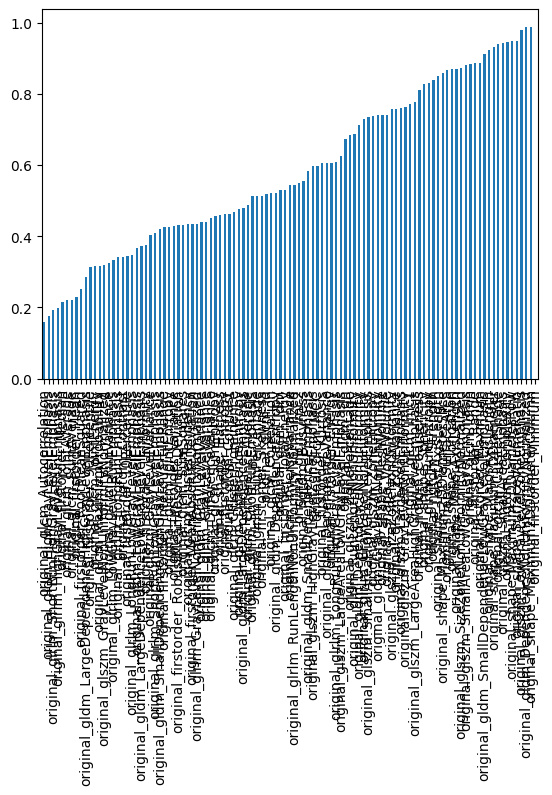

In [69]:
 from sklearn.feature_selection import chi2

chi_scores = chi2(X_train,y_train)
 
#print(p[[X_train.columns, chi_scores]])

p_values = pd.Series(chi_scores[1],index = X_train.columns)
p_values.sort_values(ascending = True , inplace = True)
display(round(p_values, 3))
p_values.plot.bar()


#print(p_values.columns.values)
df_pval = pd.DataFrame(data = p_values, 
                     columns = ['val'])
filt_pval = df_pval[df_pval['val'] < 0.50]
display(filt_pval)
print(len(filt_pval))

filt_pval.index



In [70]:
X_norm_select = X_norm[X_norm.columns.intersection(filt_pval.index)].copy()

display(X_norm_select)

original_shape_Flatness original_firstorder_10Percentile  \
0                 0.159625                              0.3   
1                 0.760906                             0.06   
2                 0.649012                              0.4   
3                 0.177044                             0.24   
4                 0.921036                             0.76   
..                     ...                              ...   
67                 0.76682                             0.04   
68                0.717097                             0.36   
69                0.428928                             0.82   
70                0.307446                             0.38   
71                0.514875                              0.1   

   original_firstorder_90Percentile original_firstorder_Entropy  \
0                          0.480315                    0.684424   
1                          0.433071                    0.660046   
2                          0.645669                    0.808329   
3                          0.251969                    0.419831   
4                          0.637795                    0.617848   
..                              ...                         ...   
67                         0.685039                    0.858978   
68                         0.559055                    0.736264   
69                         0.677165                    0.709523   
70                         0.543307                    0.697746   
71                         0.354331                    0.585696   

   original_firstorder_InterquartileRange  \
0                                0.329787   
1                                0.297872   
2                                0.414894   
3                                0.106383   
4                                0.202128   
..                                    ...   
67                               0.670213   
68                               0.340426   
69                               0.255319   
70                               0.340426   
71                               0.223404   

   original_firstorder_MeanAbsoluteDeviation original_firstorder_Mean  \
0                                      0.355                 0.565176   
1                                   0.378801                 0.348201   
2                                   0.445426                 0.760224   
3                                   0.144671                 0.322277   
4                                   0.285185                 0.956246   
..                                       ...                      ...   
67                                  0.687482                 0.630324   
68                                  0.389645                 0.595493   
69                                  0.323024                 0.957836   
70                                  0.363345                  0.65543   
71                                  0.283856                 0.322854   

   original_firstorder_Median original_firstorder_RobustMeanAbsoluteDeviation  \
0                    0.541667                                        0.327513   
1                        0.25                                        0.301598   
2                    0.736111                                        0.396834   
3                    0.305556                                         0.10998   
4                    0.972222                                        0.235019   
..                        ...                                             ...   
67                   0.611111                                        0.666699   
68                        0.5                                        0.336263   
69                   0.930556                                        0.260555   
70                      0.625                                        0.328135   
71                       0.25                                        0.227007   

   original_firstorder_RootMeanSquared  ...  \
0  

In [71]:
X_train_select,X_test_select,y_train,y_test = train_test_split(X_norm_select,y,test_size = 0.2, random_state = 4)

print(np.shape(X_train_select))
print(np.shape(X_test_select))
print(np.shape(y_train))
print(np.shape(y_test))

(57, 45)
(15, 45)
(57,)
(15,)


In [3]:
y_train

NameError: name 'y_train' is not defined

## Run ML models

In [72]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings("ignore")

In [87]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

**Decision Tree**

#-------------------------  0  ----------------------#


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             refit='Acc', return_train_score=True,
             scoring={'Acc': 'accuracy', 'f1_weighted': 'f1_weighted',
                      'precision': 'precision_weighted',
                      'recall': 'recall_weighted'})

Best params:  {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best score:  0.6984848484848485


params  Acc_Mean  Acc_StdDev  \
287  {'criterion': 'entropy', 'max_depth': 10, 'max...    0.6985    0.128064   
170  {'criterion': 'entropy', 'max_depth': None, 'm...    0.6985    0.128064   
223  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.6985    0.128064   
159  {'criterion': 'entropy', 'max_depth': None, 'm...    0.6985    0.128064   
160  {'criterion': 'entropy', 'max_depth': None, 'm...    0.6985    0.128064   
..                                                 ...       ...         ...   
174  {'criterion': 'entropy', 'max_depth': None, 'm...    0.4727    0.081114   
235  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.4712    0.071453   
217  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.4545    0.072506   
271  {'criterion': 'entropy', 'max_depth': 10, 'max...    0.4545    0.072506   
163  {'criterion': 'entropy', 'max_depth': None, 'm...    0.4545    0.072506   

     F1_Weighted_Mean  F1_Weighted_StdDev  Precision_Mean  Precision_StdDev  \
287            0.6811            0.144470          0.7151          0.132199   
170            0.6811            0.144470          0.7151          0.132199   
223            0.6811            0.144470          0.7151          0.132199   
159            0.6811            0.144470          0.7151          0.132199   
160            0.6811            0.144470          0.7151          0.132199   
..                ...                 ...             ...               ...   
174            0.4384            0.096143          0.4602          0.135959   
235            0.4446            0.086745          0.4577          0.119884   
217            0.4300            0.084725          0.4406          0.118736   
271            0.4300            0.084725          0.4406          0.118736   
163            0.4300            0.084725          0.4406          0.118736   

     Recall_Mean  Recall_StdDev  
287       0.6985       0.128064  
170       0.6985       0.128064  
223       0.6985       0.128064  
159       0.6985       0.128064  
160       0.6985       0.128064  
..           ...            ...  
174       0.4727       0.081114  
235       0.4712       0.071453  
217       0.4545       0.072506  
271       0.4545       0.072506  
163       0.4545       0.072506  

[288 rows x 9 columns]

Test score:  0.3333333333333333
TEST DATA ---- Confusion Matrix:
[[4 3]
 [7 1]]
Acc: 0.333
F1: 0.167
Prec: 0.25
Recall: 0.125


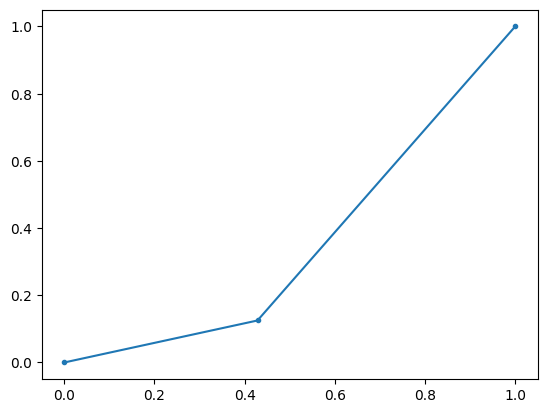

#-------------------------  1  ----------------------#


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             refit='Acc', return_train_score=True,
             scoring={'Acc': 'accuracy', 'f1_weighted': 'f1_weighted',
                      'precision': 'precision_weighted',
                      'recall': 'recall_weighted'})

Best params:  {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best score:  0.6636363636363637


params  Acc_Mean  Acc_StdDev  \
167  {'criterion': 'entropy', 'max_depth': None, 'm...    0.6636    0.160963   
176  {'criterion': 'entropy', 'max_depth': None, 'm...    0.6636    0.160963   
275  {'criterion': 'entropy', 'max_depth': 10, 'max...    0.6636    0.160963   
284  {'criterion': 'entropy', 'max_depth': 10, 'max...    0.6636    0.160963   
127  {'criterion': 'gini', 'max_depth': 10, 'max_le...    0.6515    0.086642   
..                                                 ...       ...         ...   
72   {'criterion': 'gini', 'max_depth': 5, 'max_lea...    0.4955    0.142585   
27   {'criterion': 'gini', 'max_depth': None, 'max_...    0.4939    0.100321   
129  {'criterion': 'gini', 'max_depth': 10, 'max_le...    0.4909    0.181021   
270  {'criterion': 'entropy', 'max_depth': 10, 'max...    0.4742    0.123241   
162  {'criterion': 'entropy', 'max_depth': None, 'm...    0.4727    0.102045   

     F1_Weighted_Mean  F1_Weighted_StdDev  Precision_Mean  Precision_StdDev  \
167            0.6464            0.186268          0.6513          0.216746   
176            0.6464            0.186268          0.6513          0.216746   
275            0.6464            0.186268          0.6513          0.216746   
284            0.6464            0.186268          0.6513          0.216746   
127            0.6376            0.094051          0.6899          0.098047   
..                ...                 ...             ...               ...   
72             0.4826            0.159966          0.4788          0.172115   
27             0.4627            0.119953          0.4625          0.146039   
129            0.4855            0.183837          0.4903          0.186925   
270            0.4628            0.135985          0.4619          0.147628   
162            0.4592            0.115850          0.4627          0.131375   

     Recall_Mean  Recall_StdDev  
167       0.6636       0.160963  
176       0.6636       0.160963  
275       0.6636       0.160963  
284       0.6636       0.160963  
127       0.6515       0.086642  
..           ...            ...  
72        0.4955       0.142585  
27        0.4939       0.100321  
129       0.4909       0.181021  
270       0.4742       0.123241  
162       0.4727       0.102045  

[288 rows x 9 columns]

Test score:  0.26666666666666666
TEST DATA ---- Confusion Matrix:
[[0 7]
 [4 4]]
Acc: 0.267
F1: 0.421
Prec: 0.364
Recall: 0.5


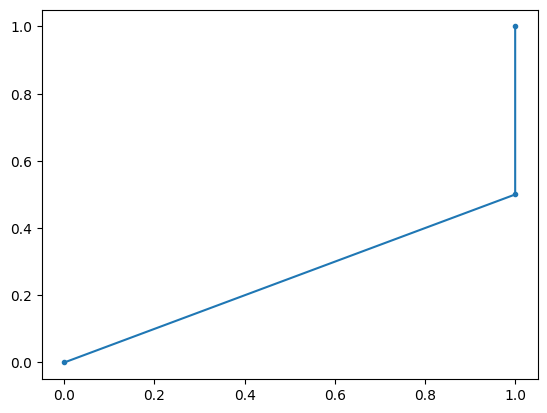

In [91]:
display(Markdown( '**Decision Tree**'))

# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }


my_scoring = {
    "Acc":"accuracy",
#     "f1_macro":"f1_macro" ,
    "f1_weighted":"f1_weighted" ,
    "precision":"precision_weighted",
    "recall": "recall_weighted",
     #"roc_auc": "roc_auc_ovr_weighted" ,
}


dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(
    dt, 
    param_grid,
    scoring = my_scoring,
    refit = "Acc",
    cv = 5,
    return_train_score = True)

grid = grid_dt


for i in range(2):
    print("#------------------------- ", i, " ----------------------#" )
    X_input_train = []
    X_input_test = []
    if (i==0):
        X_input_train = X_train
        X_input_test = X_test
    elif (i==1):
        X_input_train = X_train_select
        X_input_test = X_test_select
    
    grid_dt = GridSearchCV(
        dt, 
        param_grid,
        scoring = my_scoring,
        refit = "Acc",
        cv = 5,
        return_train_score = True)

    grid = grid_dt

    grid.fit(X_input_train, y_train)
    print("Best params: ", grid.best_params_)
    print("Best score: ", grid.best_score_)

    results = grid.cv_results_
    results_df = pd.DataFrame(list(results.items())) 

    results_table = pd.DataFrame({
        'params' :  grid.cv_results_["params"],
        'Acc_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_Acc"]],
        'Acc_StdDev' : grid.cv_results_["std_test_Acc"],
        #         'F1_Macro_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_f1_macro"]],
        #         'F1_Macro_StdDev' : grid.cv_results_["std_test_f1_macro"],
        'F1_Weighted_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_f1_weighted"]],
        'F1_Weighted_StdDev' : grid.cv_results_["std_test_f1_weighted"],
        'Precision_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_precision"]],
        'Precision_StdDev' : grid.cv_results_["std_test_precision"],
        'Recall_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_recall"]],
        'Recall_StdDev' : grid.cv_results_["std_test_recall"],
        })

    display(results_table.sort_values(by = 'Acc_Mean', ascending = False))

    print("Test score: " , grid.score(X_input_test,y_test))

    y_pred = grid.predict(X_input_test)

    print("TEST DATA ---- Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print('Acc:', round(accuracy_score(y_test, y_pred), 3))
    print('F1:', round(f1_score(y_test, y_pred), 3))
    print('Prec:', round(precision_score(y_test, y_pred), 3))
    print('Recall:', round(recall_score(y_test, y_pred), 3))
    
    y_pred_keras = grid.predict(X_input_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
    plt.show()

**SVM**

#-------------------------  0  ----------------------#


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             refit='Acc', return_train_score=True,
             scoring={'Acc': 'accuracy', 'f1_weighted': 'f1_weighted',
                      'precision': 'precision_weighted',
                      'recall': 'recall_weighted'})

Best params:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  0.7015151515151515


params  Acc_Mean  Acc_StdDev  \
27         {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}    0.7015    0.118298   
47  {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}    0.6970    0.171754   
45      {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}    0.6970    0.171754   
32    {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}    0.6970    0.171754   
42       {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}    0.6848    0.086057   
16         {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}    0.6848    0.086057   
30        {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}    0.6803    0.169832   
28        {'C': 10, 'gamma': 0.1, 'kernel': 'poly'}    0.6697    0.161248   
15          {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}    0.6667    0.102427   
44   {'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}    0.6652    0.108880   
39        {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}    0.6121    0.160306   
33       {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}    0.6121    0.111690   
4        {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}    0.6106    0.101820   
43      {'C': 100, 'gamma': 0.01, 'kernel': 'poly'}    0.6106    0.101820   
36          {'C': 100, 'gamma': 1, 'kernel': 'rbf'}    0.5970    0.120204   
24           {'C': 10, 'gamma': 1, 'kernel': 'rbf'}    0.5970    0.120204   
25          {'C': 10, 'gamma': 1, 'kernel': 'poly'}    0.5955    0.156406   
1          {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}    0.5955    0.156406   
29     {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}    0.5955    0.048768   
13           {'C': 1, 'gamma': 1, 'kernel': 'poly'}    0.5955    0.156406   
40       {'C': 100, 'gamma': 0.1, 'kernel': 'poly'}    0.5955    0.156406   
37         {'C': 100, 'gamma': 1, 'kernel': 'poly'}    0.5955    0.156406   
12            {'C': 1, 'gamma': 1, 'kernel': 'rbf'}    0.5788    0.102494   
18         {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}    0.5788    0.087905   
17      {'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}    0.5439    0.026418   
5     {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}    0.5273    0.022268   
6        {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}    0.5273    0.022268   
3         {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}    0.5273    0.022268   
8    {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}    0.5273    0.022268   
2       {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}    0.5273    0.022268   
46     {'C': 100, 'gamma': 0.001, 'kernel': 'poly'}    0.5273    0.022268   
7       {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}    0.5273    0.022268   
38      {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}    0.5273    0.022268   
14        {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}    0.5273    0.022268   
10     {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}    0.5273    0.022268   
34      {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}    0.5273    0.022268   
9       {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}    0.5273    0.022268   
31       {'C': 10, 'gamma': 0.01, 'kernel': 'poly'}    0.5273    0.022268   
11  {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}    0.5273    0.022268   
26       {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}    0.5273    0.022268   
23    {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}    0.5273    0.022268   
22       {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}    0.5273    0.022268   
21        {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}    0.5273    0.022268   
20     {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}    0.5273    0.022268   
19        {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}    0.5273    0.022268   
0           {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}    0.5273    0.022268   
35   {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}    0.5091    0.034015   
41    {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}    0.4348    0.107736   

    F1_Weighted_Mean  F1_Weighted_StdDev  Precision_Mean  Precision_StdDev  \
27            0.6925            0.124264          0.7173          0.125257   
47            0.6918            0.175804          0.7099          0.168011   
45            0.6931            0.175

Test score:  0.467
TEST DATA ---- Confusion Matrix:
[[3 4]
 [4 4]]
Acc: 0.467
F1: 0.5
Prec: 0.5
Recall: 0.5


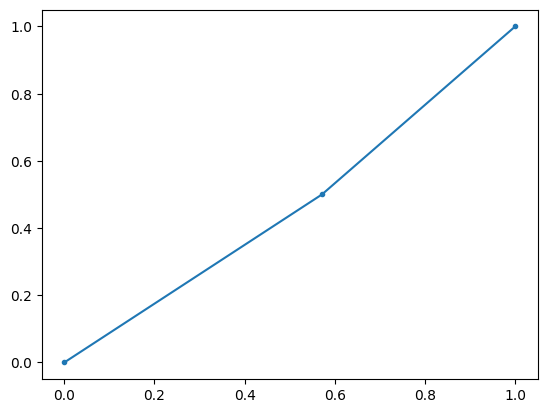

#-------------------------  1  ----------------------#


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             refit='Acc', return_train_score=True,
             scoring={'Acc': 'accuracy', 'f1_weighted': 'f1_weighted',
                      'precision': 'precision_weighted',
                      'recall': 'recall_weighted'})

Best params:  {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}
Best score:  0.7166666666666667


params  Acc_Mean  Acc_StdDev  \
47  {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}    0.7167    0.110263   
32    {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}    0.7167    0.110263   
45      {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}    0.7000    0.110263   
30        {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}    0.7000    0.110263   
44   {'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}    0.6848    0.131618   
17      {'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}    0.6833    0.047043   
15          {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}    0.6833    0.119917   
29     {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}    0.6485    0.100686   
12            {'C': 1, 'gamma': 1, 'kernel': 'rbf'}    0.6318    0.063492   
16         {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}    0.6288    0.112367   
42       {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}    0.6136    0.143740   
28        {'C': 10, 'gamma': 0.1, 'kernel': 'poly'}    0.6121    0.144250   
27         {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}    0.5985    0.171554   
41    {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}    0.5773    0.178788   
43      {'C': 100, 'gamma': 0.01, 'kernel': 'poly'}    0.5636    0.084306   
4        {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}    0.5636    0.084306   
18         {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}    0.5455    0.076060   
26       {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}    0.5439    0.026418   
31       {'C': 10, 'gamma': 0.01, 'kernel': 'poly'}    0.5273    0.022268   
34      {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}    0.5273    0.022268   
35   {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}    0.5273    0.022268   
46     {'C': 100, 'gamma': 0.001, 'kernel': 'poly'}    0.5273    0.022268   
33       {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}    0.5273    0.061658   
0           {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}    0.5273    0.022268   
10     {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}    0.5273    0.022268   
11  {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}    0.5273    0.022268   
7       {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}    0.5273    0.022268   
8    {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}    0.5273    0.022268   
3         {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}    0.5273    0.022268   
2       {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}    0.5273    0.022268   
9       {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}    0.5273    0.022268   
5     {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}    0.5273    0.022268   
6        {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}    0.5273    0.022268   
14        {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}    0.5273    0.022268   
19        {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}    0.5273    0.022268   
20     {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}    0.5273    0.022268   
21        {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}    0.5273    0.022268   
22       {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}    0.5273    0.022268   
23    {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}    0.5273    0.022268   
38      {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}    0.5258    0.044330   
39        {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}    0.5258    0.158882   
40       {'C': 100, 'gamma': 0.1, 'kernel': 'poly'}    0.4924    0.090148   
1          {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}    0.4924    0.090148   
13           {'C': 1, 'gamma': 1, 'kernel': 'poly'}    0.4909    0.124796   
24           {'C': 10, 'gamma': 1, 'kernel': 'rbf'}    0.4894    0.145927   
36          {'C': 100, 'gamma': 1, 'kernel': 'rbf'}    0.4561    0.127164   
37         {'C': 100, 'gamma': 1, 'kernel': 'poly'}    0.3182    0.095827   
25          {'C': 10, 'gamma': 1, 'kernel': 'poly'}    0.3182    0.095827   

    F1_Weighted_Mean  F1_Weighted_StdDev  Precision_Mean  Precision_StdDev  \
47            0.7068            0.119277          0.7370          0.105871   
32            0.7068            0.119277          0.7370          0.105871   
45            0.6886            0.118

Test score:  0.267
TEST DATA ---- Confusion Matrix:
[[0 7]
 [4 4]]
Acc: 0.267
F1: 0.421
Prec: 0.364
Recall: 0.5


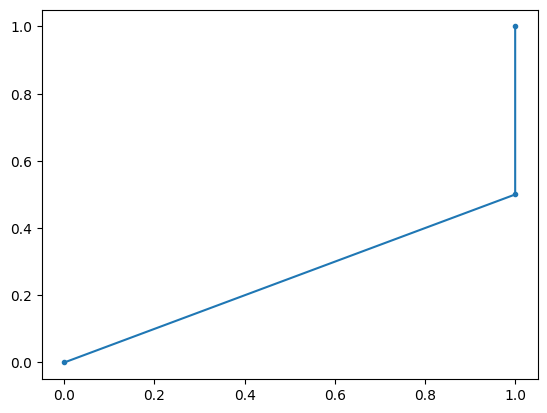

In [90]:
# SVM
display(Markdown( '**SVM**'))

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
my_svm = svm.SVC(kernel='rbf')


parameters = {
    #"estimator__C": [0.001, 0.01, 0.1, 1, 2, 5, 10],
    "estimator__C": [1],
    "estimator__kernel": ["poly","rbf"],
    "estimator__degree":[1, 2, 3, 4],
}

grid_svm = GridSearchCV(
    my_svm, 
    param_grid,
    scoring = my_scoring,
    refit = "Acc",
    cv = 5,
    return_train_score = True)

grid = grid_svm


for i in range(2):
    print("#------------------------- ", i, " ----------------------#" )
    X_input_train = []
    X_input_test = []
    if (i==0):
        X_input_train = X_train
        X_input_test = X_test
    elif (i==1):
        X_input_train = X_train_select
        X_input_test = X_test_select
    
    grid_svm = GridSearchCV(
        my_svm, 
        param_grid,
        scoring = my_scoring,
        refit = "Acc",
        cv = 5,
        return_train_score = True)

    grid = grid_svm

    grid.fit(X_input_train, y_train)
    print("Best params: ", grid.best_params_)
    print("Best score: ", grid.best_score_)

    results = grid.cv_results_
    results_df = pd.DataFrame(list(results.items())) 

    results_table = pd.DataFrame({
        'params' :  grid.cv_results_["params"],
        'Acc_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_Acc"]],
        'Acc_StdDev' : grid.cv_results_["std_test_Acc"],
        #         'F1_Macro_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_f1_macro"]],
        #         'F1_Macro_StdDev' : grid.cv_results_["std_test_f1_macro"],
        'F1_Weighted_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_f1_weighted"]],
        'F1_Weighted_StdDev' : grid.cv_results_["std_test_f1_weighted"],
        'Precision_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_precision"]],
        'Precision_StdDev' : grid.cv_results_["std_test_precision"],
        'Recall_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_recall"]],
        'Recall_StdDev' : grid.cv_results_["std_test_recall"],
        })

    display(results_table.sort_values(by = 'Acc_Mean', ascending = False))

    print("Test score: " , round(grid.score(X_input_test,y_test), 3))

    y_pred = grid.predict(X_input_test)

    print("TEST DATA ---- Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print('Acc:', round(accuracy_score(y_test, y_pred), 3))
    print('F1:', round(f1_score(y_test, y_pred), 3))
    print('Prec:', round(precision_score(y_test, y_pred), 3))
    print('Recall:', round(recall_score(y_test, y_pred), 3))
    
   
    y_pred_keras = grid.predict(X_input_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
    plt.show()


In [76]:
## RF classifier
display(Markdown( '**RF classifier**'))

# n_estimators = [100, 300, 500, 800, 1200]
n_estimators = [100, 300, 500]

#max_depth = [5, 8, 15, 25, 30]
max_depth = [5, 8, 15]
# min_samples_split = [2, 5, 10, 15, 100]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
forest = RandomForestClassifier(random_state = 1)


grid_rf = GridSearchCV(
    forest, hyperF, 
    cv = 3, verbose = 1, 
    scoring = my_scoring,
    refit = "Acc",
    n_jobs = -1)

grid = grid_rf


for i in range(2):
    print("#------------------------- ", i, " ----------------------#" )
    X_input_train = []
    X_input_test = []
    if (i==0):
        X_input_train = X_train
        X_input_test = X_test
    elif (i==1):
        X_input_train = X_train_select
        X_input_test = X_test_select
    
    grid_rf = GridSearchCV(
        forest, hyperF, 
        cv = 3, verbose = 1, 
        scoring = my_scoring,
        refit = "Acc",
        n_jobs = -1)

    grid = grid_rf

    grid.fit(X_input_train, y_train)
    print("Best params: ", grid.best_params_)
    print("Best score: ", grid.best_score_)

    results = grid.cv_results_
    results_df = pd.DataFrame(list(results.items())) 

    results_table = pd.DataFrame({
        'params' :  grid.cv_results_["params"],
        'Acc_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_Acc"]],
        'Acc_StdDev' : grid.cv_results_["std_test_Acc"],
        #         'F1_Macro_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_f1_macro"]],
        #         'F1_Macro_StdDev' : grid.cv_results_["std_test_f1_macro"],
        'F1_Weighted_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_f1_weighted"]],
        'F1_Weighted_StdDev' : grid.cv_results_["std_test_f1_weighted"],
        'Precision_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_precision"]],
        'Precision_StdDev' : grid.cv_results_["std_test_precision"],
        'Recall_Mean' : [np.round(x, 4) for x in grid.cv_results_["mean_test_recall"]],
        'Recall_StdDev' : grid.cv_results_["std_test_recall"],
        })

    display(results_table.sort_values(by = 'Acc_Mean', ascending = False))

    print("Test score: " , grid.score(X_input_test,y_test))

    y_pred = grid.predict(X_input_test)

    print("TEST DATA ---- Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print('Acc:', round(accuracy_score(y_test, y_pred), 3))
    print('F1:', round(f1_score(y_test, y_pred), 3))
    print('Prec:', round(precision_score(y_test, y_pred), 3))
    print('Recall:', round(recall_score(y_test, y_pred), 3))

**RF classifier**

#-------------------------  0  ----------------------#
Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 15],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [100, 300, 500]},
             refit='Acc',
             scoring={'Acc': 'accuracy', 'f1_weighted': 'f1_weighted',
                      'precision': 'precision_weighted',
                      'recall': 'recall_weighted'},
             verbose=1)

Best params:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 300}
Best score:  0.6842105263157894


params  Acc_Mean  Acc_StdDev  \
22   {'max_depth': 5, 'min_samples_leaf': 2, 'min_s...    0.6842    0.042974   
118  {'max_depth': 15, 'min_samples_leaf': 2, 'min_...    0.6842    0.042974   
70   {'max_depth': 8, 'min_samples_leaf': 2, 'min_s...    0.6842    0.042974   
78   {'max_depth': 8, 'min_samples_leaf': 5, 'min_s...    0.6667    0.049622   
89   {'max_depth': 8, 'min_samples_leaf': 10, 'min_...    0.6667    0.065643   
..                                                 ...       ...         ...   
98   {'max_depth': 15, 'min_samples_leaf': 1, 'min_...    0.5965    0.089456   
97   {'max_depth': 15, 'min_samples_leaf': 1, 'min_...    0.5965    0.089456   
96   {'max_depth': 15, 'min_samples_leaf': 1, 'min_...    0.5965    0.089456   
1    {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...    0.5965    0.089456   
0    {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...    0.5965    0.089456   

     F1_Weighted_Mean  F1_Weighted_StdDev  Precision_Mean  Precision_StdDev  \
22             0.6764            0.048249          0.7036          0.045395   
118            0.6764            0.048249          0.7036          0.045395   
70             0.6764            0.048249          0.7036          0.045395   
78             0.6548            0.057088          0.6898          0.040179   
89             0.6568            0.075413          0.6787          0.074385   
..                ...                 ...             ...               ...   
98             0.5766            0.109286          0.6027          0.085734   
97             0.5766            0.109286          0.6027          0.085734   
96             0.5766            0.109286          0.6027          0.085734   
1              0.5766            0.109286          0.6027          0.085734   
0              0.5766            0.109286          0.6027          0.085734   

     Recall_Mean  Recall_StdDev  
22        0.6842       0.042974  
118       0.6842       0.042974  
70        0.6842       0.042974  
78        0.6667       0.049622  
89        0.6667       0.065643  
..           ...            ...  
98        0.5965       0.089456  
97        0.5965       0.089456  
96        0.5965       0.089456  
1         0.5965       0.089456  
0         0.5965       0.089456  

[144 rows x 9 columns]

Test score:  0.26666666666666666
TEST DATA ---- Confusion Matrix:
[[0 7]
 [4 4]]
Acc: 0.267
F1: 0.421
Prec: 0.364
Recall: 0.5
#-------------------------  1  ----------------------#
Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 15],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [100, 300, 500]},
             refit='Acc',
             scoring={'Acc': 'accuracy', 'f1_weighted': 'f1_weighted',
                      'precision': 'precision_weighted',
                      'recall': 'recall_weighted'},
             verbose=1)

Best params:  {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.7017543859649122


params  Acc_Mean  Acc_StdDev  \
72   {'max_depth': 8, 'min_samples_leaf': 5, 'min_s...    0.7018    0.049622   
126  {'max_depth': 15, 'min_samples_leaf': 5, 'min_...    0.7018    0.049622   
24   {'max_depth': 5, 'min_samples_leaf': 5, 'min_s...    0.7018    0.049622   
120  {'max_depth': 15, 'min_samples_leaf': 5, 'min_...    0.7018    0.049622   
27   {'max_depth': 5, 'min_samples_leaf': 5, 'min_s...    0.7018    0.049622   
..                                                 ...       ...         ...   
61   {'max_depth': 8, 'min_samples_leaf': 2, 'min_s...    0.5789    0.085947   
13   {'max_depth': 5, 'min_samples_leaf': 2, 'min_s...    0.5789    0.085947   
15   {'max_depth': 5, 'min_samples_leaf': 2, 'min_s...    0.5789    0.085947   
111  {'max_depth': 15, 'min_samples_leaf': 2, 'min_...    0.5789    0.085947   
109  {'max_depth': 15, 'min_samples_leaf': 2, 'min_...    0.5789    0.085947   

     F1_Weighted_Mean  F1_Weighted_StdDev  Precision_Mean  Precision_StdDev  \
72             0.6919            0.052024          0.7362          0.078048   
126            0.6919            0.052024          0.7362          0.078048   
24             0.6919            0.052024          0.7362          0.078048   
120            0.6919            0.052024          0.7362          0.078048   
27             0.6919            0.052024          0.7362          0.078048   
..                ...                 ...             ...               ...   
61             0.5696            0.087848          0.5825          0.084011   
13             0.5696            0.087848          0.5825          0.084011   
15             0.5696            0.087848          0.5825          0.084011   
111            0.5696            0.087848          0.5825          0.084011   
109            0.5696            0.087848          0.5825          0.084011   

     Recall_Mean  Recall_StdDev  
72        0.7018       0.049622  
126       0.7018       0.049622  
24        0.7018       0.049622  
120       0.7018       0.049622  
27        0.7018       0.049622  
..           ...            ...  
61        0.5789       0.085947  
13        0.5789       0.085947  
15        0.5789       0.085947  
111       0.5789       0.085947  
109       0.5789       0.085947  

[144 rows x 9 columns]

Test score:  0.26666666666666666
TEST DATA ---- Confusion Matrix:
[[0 7]
 [4 4]]
Acc: 0.267
F1: 0.421
Prec: 0.364
Recall: 0.5


In [93]:
## Neural network classifier
#from keras.models import Sequential
from tensorflow.keras.models import Sequential
#from keras.layers import Dense
from tensorflow.keras.layers import Dense

display(Markdown( '**NN classifier**'))


for i in range(2):
    print("#------------------------- ", i, " ----------------------#" )
    X_input_train = []
    X_input_test = []
    
    if (i==0):
        X_input_train = X_train
        X_input_test = X_test
    elif (i==1):
        X_input_train = X_train_select
        X_input_test = X_test_select
    
    print(X_input_train.shape)
    # define the keras model
    model = Sequential()
    model.add(Dense(24, input_dim=X_input_train.shape[1], activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    X_input_train = np.asarray(X_input_train).astype('float32')
    X_input_test = np.asarray(X_input_test).astype('float32')
    
    model.fit(X_input_train, y_train, batch_size = 10, epochs = 50)
#     print("Best params: ", grid.best_params_)
#     print("Best score: ", grid.best_score_)

#     results = grid.cv_results_
#     results_df = pd.DataFrame(list(results.items())) 

    _, accuracy = model.evaluate(X_input_train, y_train)
    print('Accuracy: %.2f' % (accuracy*100))
    
    y_pred = np.rint(model.predict(X_input_test))

    print("TEST DATA ---- Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print('Acc:', round(accuracy_score(y_test, y_pred), 3))
    print('F1:', round(f1_score(y_test, y_pred), 3))
    print('Prec:', round(precision_score(y_test, y_pred), 3))
    print('Recall:', round(recall_score(y_test, y_pred), 3))

#     y_pred_keras = grid.predict(X_input_test).ravel()
#     fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

#     auc_keras = auc(fpr_keras, tpr_keras)
#     plt.plot(fpr_keras, tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
#     plt.show()

**NN classifier**

#-------------------------  0  ----------------------#
(57, 107)
Epoch 1/50
6/6 [==============================] - 1s 3ms/step - loss: 0.7608 - accuracy: 0.4737
Epoch 2/50
6/6 [==============================] - 0s 2ms/step - loss: 0.7243 - accuracy: 0.4737
Epoch 3/50
6/6 [==============================] - 0s 1ms/step - loss: 0.6969 - accuracy: 0.4737
Epoch 4/50
6/6 [==============================] - 0s 2ms/step - loss: 0.6877 - accuracy: 0.4912
Epoch 5/50
6/6 [==============================] - 0s 1ms/step - loss: 0.6812 - accuracy: 0.5439
Epoch 6/50
6/6 [==============================] - 0s 1ms/step - loss: 0.6743 - accuracy: 0.6140
Epoch 7/50
6/6 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6667
Epoch 8/50
6/6 [==============================] - 0s 2ms/step - loss: 0.6628 - accuracy: 0.7018
Epoch 9/50
6/6 [==============================] - 0s 2ms/step - loss: 0.6560 - accuracy: 0.6667
Epoch 10/50
6/6 [==============================] - 0s 2ms/step - loss: 

2/2 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.8070
Accuracy: 80.70
TEST DATA ---- Confusion Matrix:
[[0 7]
 [4 4]]
Acc: 0.267
F1: 0.421
Prec: 0.364
Recall: 0.5
#-------------------------  1  ----------------------#
(57, 45)
Epoch 1/50
6/6 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.4737
Epoch 2/50
6/6 [==============================] - 0s 1ms/step - loss: 0.6831 - accuracy: 0.5614
Epoch 3/50
6/6 [==============================] - 0s 1ms/step - loss: 0.6711 - accuracy: 0.6667
Epoch 4/50
6/6 [==============================] - 0s 960us/step - loss: 0.6637 - accuracy: 0.6491
Epoch 5/50
6/6 [==============================] - 0s 1ms/step - loss: 0.6553 - accuracy: 0.7018
Epoch 6/50
6/6 [==============================] - 0s 1ms/step - loss: 0.6458 - accuracy: 0.7544
Epoch 7/50
6/6 [==============================] - 0s 1ms/step - loss: 0.6382 - accuracy: 0.7193
Epoch 8/50
6/6 [==============================] - 0s 1ms/step - loss

2/2 [==============================] - 0s 1ms/step - loss: 0.5411 - accuracy: 0.7018
Accuracy: 70.18
TEST DATA ---- Confusion Matrix:
[[0 7]
 [4 4]]
Acc: 0.267
F1: 0.421
Prec: 0.364
Recall: 0.5


In [ ]:
### ROCAUC Curve

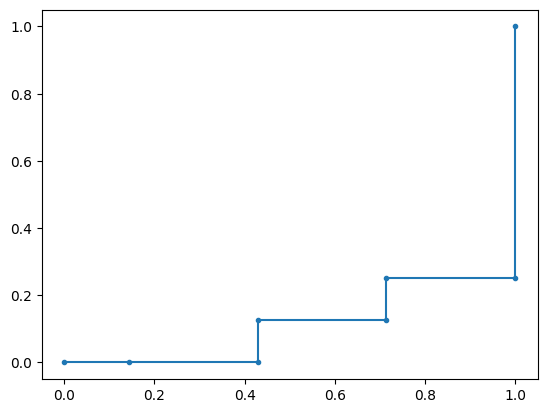

In [84]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_input_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)


In [85]:
y_pred_keras

array([0.8629248 , 0.7512931 , 0.25928742, 0.673498  , 0.29320434,
       0.8908128 , 0.320713  , 0.68408805, 0.6876911 , 0.73676324,
       0.29290426, 0.69610125, 0.67518085, 0.80046463, 0.7485126 ],
      dtype=float32)

# CNN Classifier using Segmented Voxel Data
## (Run on Google Collab Pro+ for increased computing resources)

In [11]:
# ---------------- import Deep Learning packages

# ------- various math pkgs pkgs
import random

# ------- various ML pkgs
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
#import pandas as pd

# ------- keras and tensorflow pkgs
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
import sklearn
import keras
import tensorflow as tf


from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import initializers



In [2]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args
    ----
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure


def normalize(volume):
    """Normalizes volume and returns object
    Args
    ----
    volume = 3D object
    """
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def plot_slices(data, num_rows, num_columns, width=128, height=128):
    """Plot a montage of 20 CT slices
    
    Args
    ----
    num_rows = number of rows in montage
    num_columns = number of columns in montage
    width = number of pixels of each slice
    height = number of pixels of each slice
    data = voxel data in np array
    """
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

### Load data from pickle object

In [149]:
dataset_full.shape

(199, 154, 167, 72)

### reshape voxel data into (n, , , , ) where n = num_cases

In [16]:
dataset_full_reformat =  np.zeros((
    np.shape(dataset_full)[3],
    np.shape(dataset_full)[0],
    np.shape(dataset_full)[1],
    np.shape(dataset_full)[2]))

for i in range(0,np.shape(dataset_full_reformat)[0]):
    dataset_full_reformat[i,:,:,:] = dataset_full[:,:,:,i]
    
print(np.shape(dataset_full_reformat))

(72, 199, 154, 167)


### Normalize voxel data

In [17]:
from sklearn.preprocessing import MinMaxScaler

# normalize on masked data
dataset_full_norm = dataset_full_reformat/ 255.0

### Create X and y dataframes

In [18]:
id_labels = []
for case_dir in all_cases:
    #print(case_dir)
    id_labels.append(case_dir)

print(id_labels)

outcome_df = pd.read_excel('/Users/alexandrabourdillon/Documents/Yale/Oto/DL_LN_Thesis/outcome_sept1.xlsm', sheet_name ="outcome" )
outcome_df = outcome_df[outcome_df['ID'].notna()]
outcome_df = pd.DataFrame(outcome_df)[['ID', 'final_grade', 'dx_class']]

outcome_df.ID = outcome_df.ID.astype("category")
outcome_df.ID.cat.set_categories(id_labels, inplace=True)
outcome_df = outcome_df.sort_values(["ID"]) 
outcome_df = outcome_df[outcome_df['ID'].notna()]
outcome_df


outcome_df['dx_class_2'] = list(map(lambda b : 1.0 if b else 0.0, outcome_df.dx_class.str.match('cancer|temp')))

display(outcome_df)


['132', '103', '168', '192', '194', '193', '024', '015', '137b', '014', '047', '096', '053', '098', '038', '009', '204', '203', '052', '090', '037', '205', '001', '174', '162c', '036a', '128b', '129', '116', '111', '118', '143', '144', '162b', '121', '119', '079b', '117', '165', '190', '155', '199', '130', '042', '137a', '080', '027', '016', '075', '086', '044', '017', '010', '003', '004', '200', '059', '201', '005', '002', '051', '112', '115', '036b', '148', '128a', '125', '114', '079a', '182', '176', '185']


ID  final_grade dx_class
133   132          4.0   cancer
103   103          4.0   cancer
171   168          2.0   cancer
195   192          3.0   benign
197   194          3.0   benign
..    ...          ...      ...
114   114          2.0   benign
78   079a          3.0   cancer
185   182          3.0   cancer
179   176          3.0   cancer
188   185          4.0   cancer

[72 rows x 3 columns]

ID  final_grade dx_class  dx_class_2
133   132          4.0   cancer         1.0
103   103          4.0   cancer         1.0
171   168          2.0   cancer         1.0
195   192          3.0   benign         0.0
197   194          3.0   benign         0.0
..    ...          ...      ...         ...
114   114          2.0   benign         0.0
78   079a          3.0   cancer         1.0
185   182          3.0   cancer         1.0
179   176          3.0   cancer         1.0
188   185          4.0   cancer         1.0

[72 rows x 4 columns]

In [19]:
X = dataset_full_norm
y = outcome_df['dx_class_2']
sample_shape = np.shape(X)

In [20]:
print(np.shape(X))
print(np.shape(y))

(72, 199, 154, 167)
(72,)


###  Create training and testing datasets

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

#X_train = tf.expand_dims(X_train, axis=-1)
#X_test = tf.expand_dims(X_test, axis=-1)
# np.shape(X_train)
# np.shape(X_test)

print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)

Training data shape :  (57, 199, 154, 167) (57,)
Testing data shape :  (15, 199, 154, 167) (15,)


### Data augmentation

In [22]:
########################## link: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/3D_image_classification.ipynb#scrollTo=EH45UEnnKBYd
import random
import scipy
from scipy import ndimage

def show_mid_slice(img_numpy, title='img'):
   """
   Accepts an 3D numpy array and shows median slices in all three planes
   """
   assert img_numpy.ndim == 3
   n_i, n_j, n_k = img_numpy.shape

   # sagittal (left image)
   center_i1 = int((n_i - 1) / 2)
   # coronal (center image)
   center_j1 = int((n_j - 1) / 2)
   # axial slice (right image)
   center_k1 = int((n_k - 1) / 2)

   show_slices([img_numpy[center_i1, :, :],
                img_numpy[:, center_j1, :],
                img_numpy[:, :, center_k1]])
   plt.suptitle(title)

def show_slices(slices):
   """
   Function to display a row of image slices
   Input is a list of numpy 2D image slices
   """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")


def random_zoom(matrix,min_percentage=0.7, max_percentage=1.2):
   z = np.random.sample() *(max_percentage-min_percentage) + min_percentage
   zoom_matrix = np.array([[z, 0, 0, 0],
                           [0, z, 0, 0],
                           [0, 0, z, 0],
                           [0, 0, 0, 1]])
   return ndimage.interpolation.affine_transform(matrix, zoom_matrix)


def random_rotate3D(img_numpy, min_angle, max_angle):
   """
   Returns a random rotated array in the same shape
   :param img_numpy: 3D numpy array
   :param min_angle: in degrees
   :param max_angle: in degrees
   """
   assert img_numpy.ndim == 3, "provide a 3d numpy array"
   assert min_angle < max_angle, "min should be less than max val"
   assert min_angle > -360 or max_angle < 360
   #all_axes = [(1, 0), (1, 2), (0, 2)]
   all_axes = [(1,0)]
   angle = np.random.randint(low=min_angle, high=max_angle+1)
   axes_random_id = np.random.randint(low=0, high=len(all_axes))
   axes = all_axes[axes_random_id]
   #return scipy.ndimage.rotate(img_numpy, angle, axes=axes)
   return scipy.ndimage.rotate(img_numpy, angle, axes=axes, reshape = False)


def random_flip(img, label=None):
   axes = [0, 1, 2]
   rand = np.random.randint(0, 3)
   img = flip_axis(img, axes[rand])
   img = np.squeeze(img)

   if label is None:
     return img
   else:
     y = flip_axis(y, axes[rand])
     y = np.squeeze(y)
   return x, y

def flip_axis(x, axis):
   x = np.asarray(x).swapaxes(axis, 0)
   x = x[::-1, ...]
   x = x.swapaxes(0, axis)
   return x


In [23]:
import random as rand

X_train_augment = X_train.copy()

for i in range(np.shape(X_train_augment)[0]):
    curr = X_train_augment[i,:,:,:]
    if (rand.randint(0,1) == 1):
        curr =  flip_axis(curr, axis = 0)
    if (rand.randint(0,1) == 1):
        curr =  flip_axis(curr, axis = 1)
    if (rand.randint(0,1) == 1):
        curr = random_rotate3D(curr, 0, 5)
    X_train_augment[i,:,:,:] = curr

print(np.shape(X_train_augment))


(57, 199, 154, 167)


In [26]:
import tensorflow as tf

In [27]:
# ----------- concatenate original and augmented scans

X_train_full = np.concatenate((tf.expand_dims(X_train, axis=-1), tf.expand_dims(X_train_augment, axis=-1)), axis = 0)
np.shape(X_train_full)

y_train_full = np.concatenate((y_train, y_train), axis = 0)

print('Training data shape : ', X_train_full.shape, y_train_full.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)

(114, 199, 154, 167, 1)

Training data shape :  (114, 199, 154, 167, 1) (114,)
Testing data shape :  (15, 199, 154, 167) (15,)


In [28]:
pickle_save(X_train_full, 'cnm_X_train_full_jan19.pickle')
pickle_save(y_train_full, 'cnm_y_train_full_jan19.pickle')
pickle_save(X_test, 'cnm_X_test_jan19.pickle')
pickle_save(y_test, 'cnm_y_test_jan19.pickle')

In [29]:
pickle_save(X_train_full[0:72,:,:,:], 'cnm_X_train_full_0_72_jan19.pickle')
pickle_save(X_train_full[72:,:,:,:], 'cnm_X_train_full_72_114_jan19.pickle')

In [32]:
outcome_train, outcome_test = train_test_split(outcome_df, test_size=0.2, random_state=4)


In [35]:
# outcome_train.to_excel('outcome_train_jan19.xlsx')
# outcome_test.to_excel('outcome_test_jan19.xlsx')
outcome_train

ID  final_grade dx_class  dx_class_2
46    047          3.0   benign         0.0
98    098          4.0   benign         0.0
13    015          3.0   benign         0.0
22    024          4.0   cancer         1.0
165  162c          4.0   cancer         1.0
96    096          2.0   benign         0.0
50    051          4.0   benign         0.0
0     001          4.0   benign         0.0
51    052          3.0   cancer         1.0
58    059          3.0   cancer         1.0
52    053          4.0   cancer         1.0
193   190          3.0   benign         0.0
130   129          4.0   benign         0.0
1     002          2.0   cancer         1.0
34   036a          4.0   cancer         1.0
74    075          4.0   cancer         1.0
207   204          2.0   cancer         1.0
206   203          4.0   benign         0.0
145   143          4.0   benign         0.0
121   121          3.0  cancer          1.0
7     009          4.0   cancer         1.0
3     004          4.0   benign         0.0
116   116          3.0   cancer         1.0
202   199          4.0   benign         0.0
164  162b          3.0   cancer         1.0
112   112          4.0   benign         0.0
146   144          3.0   benign         0.0
177   174          4.0   cancer         1.0
14    016          4.0   cancer         1.0
139  137b          3.0   benign         0.0
118   118          3.0   benign         0.0
188   185          4.0   cancer         1.0
171   168          2.0   cancer         1.0
86    086          3.0   benign         0.0
115   115          2.0   benign         0.0
125   125          3.0   cancer         1.0
35   036b          3.0   cancer         1.0
208   205          2.0   benign         0.0
133   132          4.0   cancer         1.0
195   192          3.0   benign         0.0
8     010          3.0   cancer         1.0
131   130          3.0   benign         0.0
168   165          4.0   benign         0.0
138  137a          3.0   benign         0.0
114   114          2.0   benign         0.0
79   079b          3.0   cancer         1.0
157   155          3.0   cancer         1.0
204   201          4.0   cancer         1.0
150   148          2.0   benign         0.0
179   176          3.0   cancer         1.0
4     005          3.0   cancer         1.0
12    014          4.0   cancer         1.0
43    044          4.0   benign         0.0
103   103          4.0   cancer         1.0
185   182          3.0   cancer         1.0
203   200          4.0   cancer         1.0
25    027          3.0   cancer         1.0

In [34]:
y_train

46     0.0
98     0.0
13     0.0
22     1.0
165    1.0
96     0.0
50     0.0
0      0.0
51     1.0
58     1.0
52     1.0
193    0.0
130    0.0
1      1.0
34     1.0
74     1.0
207    1.0
206    0.0
145    0.0
121    1.0
7      1.0
3      0.0
116    1.0
202    0.0
164    1.0
112    0.0
146    0.0
177    1.0
14     1.0
139    0.0
118    0.0
188    1.0
171    1.0
86     0.0
115    0.0
125    1.0
35     1.0
208    0.0
133    1.0
195    0.0
8      1.0
131    0.0
168    0.0
138    0.0
114    0.0
79     1.0
157    1.0
204    1.0
150    0.0
179    1.0
4      1.0
12     1.0
43     0.0
103    1.0
185    1.0
203    1.0
25     1.0
Name: dx_class_2, dtype: float64


### Build model

In [ ]:
'''
  A simple Conv3D example with TensorFlow 2 based Keras
'''
import tensorflow
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt

# -- Preparatory code --
# Model configuration
batch_size = 100
no_epochs = 50
learning_rate = 0.001
no_classes = 10
validation_split = 0.2
verbosity = 1
input_width = np.shape(X_train)[1]
input_height = np.shape(X_train)[2]
input_depth = np.shape(X_train)[3]


In [25]:
# Create the model
model_cnn = Sequential()
model_cnn.add(layers.Conv3D(16, (3, 3, 3),activation='relu', 
                        input_shape=(input_width, input_height, input_depth, 1)))
model_cnn.add(layers.Conv3D(16, (3, 3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling3D((2, 2, 2)))
# model_cnn.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
# model_cnn.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
# model_cnn.add(layers.MaxPooling3D((2, 2, 2)))
# model_cnn.add(layers.Conv3D(256, (3, 3, 3), activation='relu'))
# model_cnn.add(layers.Conv3D(256, (3, 3, 3), activation='relu'))
# model_cnn.add(layers.MaxPooling3D((2, 2, 2)))
model_cnn.add(layers.Conv3D(32, (3, 3, 3), activation='relu'))
model_cnn.add(layers.Conv3D(32, (3, 3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling3D((2, 2, 2)))
model_cnn.add(layers.Conv3D(16, (3, 3, 3), activation='relu'))
model_cnn.add(layers.Conv3D(16, (3, 3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling3D((2, 2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(8, activation='softmax'))
model_cnn.add(layers.Dense(10))
model_cnn.add(layers.Dense(1, activation = 'sigmoid'))
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 197, 152, 165, 16) 448       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 195, 150, 163, 16) 6928      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 97, 75, 81, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 95, 73, 79, 32)    13856     
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 93, 71, 77, 32)    27680     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 46, 35, 38, 32)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 44, 33, 36, 16)   

In [26]:
model_cnn.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['acc'])

In [27]:
y_train_full

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.])

### Train model

In [ ]:
model_cnn.fit(x=X_train_full, y=y_train_full,
    epochs=30, 
    batch_size=20, 
    validation_split=0.2)

In [ ]:
model_cnn.save('model_cnn_01.h5')

### Evaluate model on test data

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("CNN model, accuracy: {:5.2f}%".format(100 * acc))

In [36]:
## visualizations

In [45]:

import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

NumDots = 4
NumConvMax = 16
NumFcMax = 16
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Darker = 0.15
Black = 0.


def add_layer(patches, colors, size=(24, 24), num=5,
              top_left=[0, 0],
              loc_diff=[3, -3],
              ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size[1], size[0]))
        if ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_layer_with_omission(patches, colors, size=(24, 24),
                            num=5, num_max=8,
                            num_dots=4,
                            top_left=[0, 0],
                            loc_diff=[3, -3],
                            ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    this_num = min(num, num_max)
    start_omit = (this_num - num_dots) // 2
    end_omit = this_num - start_omit
    start_omit -= 1
    for ind in range(this_num):
        if (num > num_max) and (start_omit < ind < end_omit):
            omit = True
        else:
            omit = False

        if omit:
            patches.append(
                Circle(loc_start + ind * loc_diff + np.array(size) / 2, 0.5))
        else:
            patches.append(Rectangle(loc_start + ind * loc_diff,
                                     size[1], size[0]))

        if omit:
            colors.append(Black)
        elif ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_mapping(patches, colors, start_ratio, end_ratio, patch_size, ind_bgn,
                top_left_list, loc_diff_list, num_show_list, size_list):

    start_loc = top_left_list[ind_bgn] \
        + (num_show_list[ind_bgn] - 1) * np.array(loc_diff_list[ind_bgn]) \
        + np.array([start_ratio[0] * (size_list[ind_bgn][1] - patch_size[1]),
                    - start_ratio[1] * (size_list[ind_bgn][0] - patch_size[0])]
                   )




    end_loc = top_left_list[ind_bgn + 1] \
        + (num_show_list[ind_bgn + 1] - 1) * np.array(
            loc_diff_list[ind_bgn + 1]) \
        + np.array([end_ratio[0] * size_list[ind_bgn + 1][1],
                    - end_ratio[1] * size_list[ind_bgn + 1][0]])


    patches.append(Rectangle(start_loc, patch_size[1], -patch_size[0]))
    colors.append(Dark)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)



def label(xy, text, xy_off=[0, 4]):
    plt.text(xy[0] + xy_off[0], xy[1] + xy_off[1], text,
             family='sans-serif', size=8)


if __name__ == '__main__':

    fc_unit_size = 2
    layer_width = 40
    flag_omit = True

    patches = []
    colors = []

    fig, ax = plt.subplots()


    ############################
    # conv layers
    size_list = [(16,16,16), (16,16,16), (8,8,8), (8,8,8),]
    num_list = [16, 16, 8,8]
    x_diff_list = [0, layer_width, layer_width, layer_width, layer_width]
    text_list = ['Inputs'] + ['Feature\nmaps'] * (len(size_list) - 1)
    loc_diff_list = [[3, -3]] * len(size_list)

    num_show_list = list(map(min, num_list, [NumConvMax] * len(num_list)))
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]

    for ind in range(len(size_list)-1,-1,-1):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumConvMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}@{}x{}x{}'.format(
            num_list[ind], size_list[ind][0], size_list[ind][1], size_list[ind][2]))

    ############################
    # in between layers
    start_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5]]
    end_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5]]
    patch_size_list = [(5, 5, 5), (2, 2,2), (5, 5,5), (2, 2,2)]
    ind_bgn_list = range(len(patch_size_list))
    text_list = ['Convolution', 'Max-pooling', 'Convolution', 'Max-pooling']

    for ind in range(len(patch_size_list)):
        add_mapping(
            patches, colors, start_ratio_list[ind], end_ratio_list[ind],
            patch_size_list[ind], ind,
            top_left_list, loc_diff_list, num_show_list, size_list)
        label(top_left_list[ind], text_list[ind] + '\n{}x{}x{} kernel'.format(
            patch_size_list[ind][0], patch_size_list[ind][1], patch_size_list[ind][2]), xy_off=[26, -65]
        )


    ############################
    # fully connected layers
    size_list = [(fc_unit_size, fc_unit_size)] * 3
    num_list = [768, 500, 2]
    num_show_list = list(map(min, num_list, [NumFcMax] * len(num_list)))
    x_diff_list = [sum(x_diff_list) + layer_width, layer_width, layer_width]
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]
    loc_diff_list = [[fc_unit_size, -fc_unit_size]] * len(top_left_list)
    text_list = ['Hidden\nunits'] * (len(size_list) - 1) + ['Outputs']

    for ind in range(len(size_list)):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumFcMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind],
                      loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}'.format(
            num_list[ind]))

    text_list = ['Flatten\n', 'Fully\nconnected', 'Fully\nconnected']

    for ind in range(len(size_list)):
        label(top_left_list[ind], text_list[ind], xy_off=[-10, -65])

    ############################
    for patch, color in zip(patches, colors):
        patch.set_color(color * np.ones(3))
        if isinstance(patch, Line2D):
            ax.add_line(patch)
        else:
            patch.set_edgecolor(Black * np.ones(3))
            ax.add_patch(patch)

    plt.tight_layout()
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    fig.set_size_inches(8, 2.5)

    fig_dir = './'
    fig_ext = '.png'
    fig.savefig(os.path.join(fig_dir, 'miccai_convnet_fig' + fig_ext),
                bbox_inches='tight', pad_inches=0)

IndexError: list index out of range